In [5]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
technical_indicators_scaled_day = pd.read_csv('/content/drive/My Drive/technical_indicators_scaled_day.csv', index_col=0)
ticker_data_day = pd.read_csv('/content/drive/My Drive/ticker_data_day.csv', index_col=0)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Define a function to label the data based on the fixed number of days (d)
def label_data_fixed_days(row_index, d, close_prices, binary=True):
    if row_index + d >= len(close_prices):
        return None
    current_price = close_prices.iloc[row_index]
    future_price = close_prices.iloc[row_index + d]
    if binary:
        return 1 if future_price > current_price else 0
    else:
        return 1 if future_price > current_price else -1


15/15 [==============================] - 0s 2ms/step
d = 1, Selected features: SMA21, EMA7, EMA21, BB_upper, BB_middle, BB_lower, OBV
d = 1, Average accuracy: 0.603956043956044
15/15 [==============================] - 0s 2ms/step
d = 2, Selected features: SMA21, EMA7, EMA21, BB_upper, BB_middle, BB_lower, OBV
d = 2, Average accuracy: 0.6197802197802198
15/15 [==============================] - 0s 2ms/step
d = 3, Selected features: SMA21, EMA7, EMA21, BB_upper, BB_middle, BB_lower, OBV
d = 3, Average accuracy: 0.5613186813186813
15/15 [==============================] - 0s 3ms/step
d = 4, Selected features: SMA21, EMA7, EMA21, BB_upper, BB_middle, BB_lower, OBV
d = 4, Average accuracy: 0.6030769230769231
15/15 [==============================] - 0s 2ms/step
d = 5, Selected features: SMA21, EMA7, EMA21, BB_upper, BB_middle, BB_lower, OBV
d = 5, Average accuracy: 0.5635164835164834
15/15 [==============================] - 0s 3ms/step
d = 6, Selected features: SMA21, EMA7, EMA21, BB_upper, BB

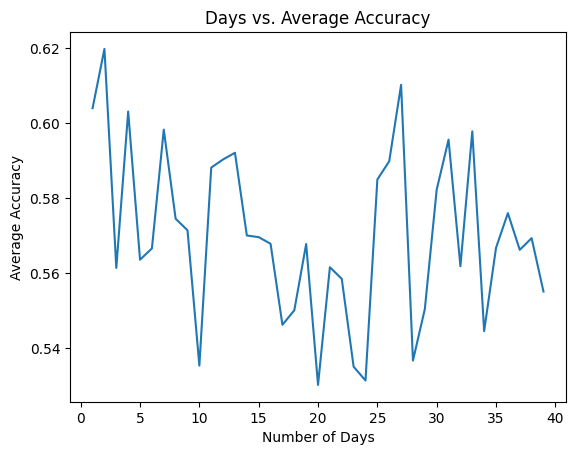

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import matplotlib.pyplot as plt

d_values = list(range(1, 40))  # Test different values of d
best_d, best_model, best_accuracy, best_report = None, None, 0, None
accuracy_results = []

for d in d_values:
    # Label the data using the current value of d
    technical_indicators_scaled_day['Label'] = 0
    for idx in range(len(technical_indicators_scaled_day)):
        binary_label = label_data_fixed_days(idx, d, ticker_data_day['Close'], binary=True)
        if binary_label is not None:
            technical_indicators_scaled_day.loc[technical_indicators_scaled_day.index[idx], 'Label'] = binary_label

    y = technical_indicators_scaled_day['Label'].values
    X = technical_indicators_scaled_day.drop(columns=['Label'])

    # Remove the last d rows
    X = X.iloc[:-d]
    y = y[:-d]

    k = 7  # Select the top k features
    selector = SelectKBest(score_func=mutual_info_classif, k=k)
    X_kbest = selector.fit_transform(X, y)
    X_kbest = X_kbest.reshape(-1, 1, k)  # Reshape the input data into a 3D array as required by LSTM
    selected_features = X.columns[selector.get_support()]

    # Define the LSTM model
    model = Sequential()
    model.add(LSTM(units=150, activation='tanh', input_shape=(1, k)))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    tscv = TimeSeriesSplit(n_splits=5)
    accuracy_scores = []
    y_true_all = []
    y_pred_all = []

    for train_index, test_index in tscv.split(X_kbest):
        X_train, X_test = X_kbest[train_index], X_kbest[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Train the model
        model.fit(X_train, y_train, epochs=200, batch_size=64, verbose=0)

        # Evaluate the model
        y_pred = (model.predict(X_test) > 0.5).astype("int32")
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)

        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred.flatten())

    # Calculate the average accuracy
    average_accuracy = np.mean(accuracy_scores)
    accuracy_results.append(average_accuracy)

    if average_accuracy > best_accuracy:
        best_d = d
        best_accuracy = average_accuracy
        best_model = model
        best_report = classification_report(y_true_all, y_pred_all)

    print(f"d = {d}, Selected features: {', '.join(selected_features)}")
    print(f"d = {d}, Average accuracy: {average_accuracy}")

print(f"Best d value: {best_d}, with average accuracy: {best_accuracy}")
print("\nClassification report:")
print(best_report)

# Plot the accuracy graph
plt.plot(d_values, accuracy_results)
plt.xlabel("Number of Days")
plt.ylabel("Average Accuracy")
plt.title("Days vs. Average Accuracy")
plt.show()
